In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

with gzip.open(path_gz, 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])


# Initial Setup

## Data

In [3]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [4]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]

  def __call__(self, x):
    for l in self.layers: 
      x = l(x)
    return x

In [5]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

## Cross Entropy Loss

In [6]:
def log_softmax(x):
  return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [7]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

In [8]:
def logsumexp(x):
  m = x.max(-1)[0]
  return m + (x - m[:, None]).exp().sum(-1).log()

In [9]:
def log_softmax(x):
  return x - x.logsumexp(-1, keepdim=True)

In [10]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred[0,5], sm_pred[1,0], sm_pred[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [13]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [14]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

In [15]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

# Using parameters and optim

## Parameters

In [16]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [17]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [18]:
m1.named_children()

<generator object Module.named_children at 0x7fb99780e0a0>

In [19]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [20]:
class MLP(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
    self.relu = nn.ReLU()
  
  def __call__(self, x):
    return self.l2(self.relu(self.l1(x)))

In [21]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [22]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [23]:
for name, l in model.named_children():
  print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [24]:
for p in model.parameters():
  print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [25]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for
bs=50                  # batch size
xb = x_train[0:bs]     # a mini-batch from x

loss_func = F.cross_entropy

#|export
def accuracy(out, yb): 
  return (out.argmax(dim=1)==yb).float().mean()

def report(loss, preds, yb): 
  print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')


In [26]:
def fit():
  for epoch in range(epochs):
    for i in range(0, n, bs):
      s = slice(i, min(n, i+bs))
      xb, yb = x_train[s], y_train[s]
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * lr
        model.zero_grad()
    report(loss, preds, yb)

In [27]:
fit()

0.19, 0.96
0.11, 0.96
0.04, 1.00


In [28]:
class MyModule:
  def __init__(self, n_in, nh, n_out):
    self._modules = {}
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
  
  def __setattr__(self, k, v):
    if not k.startswith("_"):
      self._modules[k] = v
    super().__setattr__(k,v)
  
  def __repr__(self):
    return f'{self._modules}'
  
  def parameters(self):
    for l in self._modules.values():
      yield from l.parameters()

In [29]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [30]:
for p in mdl.parameters():
  print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## Registering Modules

In [31]:
from functools import reduce

In [32]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10) ]

In [33]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): 
          self.add_module(f'layer_{i}', l)

    def forward(self, x): 
      return reduce(lambda val,layer: layer(val), self.layers, x)


In [34]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [35]:
model(xb).shape

torch.Size([50, 10])

## nn.Sequential

In [36]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [37]:
yb = y_train[0:bs]

fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.15, 0.96
0.11, 0.96
0.09, 0.94


(tensor(0.07, grad_fn=<NllLossBackward0>), tensor(0.98))

In [38]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

In [39]:
class Optimizer():
  def __init__(self, params, lr=0.5):
    self.params = list(params)
    self.lr = lr
  
  def step(self):
    with torch.no_grad():
      for p in self.params:
        p -= p.grad * self.lr
    
  def zero_grad(self):
    for p in self.params:
      p.grad.data.zero_()

In [40]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10))

In [41]:
opt = Optimizer(model.parameters())

In [42]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n, i+bs))
    xb, yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


In [43]:
from torch import optim

In [44]:
def get_model():
  model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10))
  return model, optim.SGD(model.parameters(), lr=lr)

In [45]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [46]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n, i+bs))
    xb, yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.38, 0.88
0.37, 0.90
0.23, 0.92


# Dataset and DataLoader

## Dataset

In [47]:
class Dataset():
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def __len__(self):
    return len(self.x)
  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [48]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [49]:
xb, yb = train_ds[0:5]

assert xb.shape == (5, 28*28)
assert yb.shape == (5,)

In [50]:
model, opt = get_model()

In [51]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    xb, yb = train_ds[i:min(n, bs+i)]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.26, 0.88
0.13, 0.96
0.08, 0.96


## DataLoader

In [52]:
class DataLoader():
  def __init__(self, ds, bs):
    self.ds = ds
    self.bs = bs

  def __iter__(self):
    for i in range(0, len(self.ds), self.bs):
      yield self.ds[i:i+self.bs]

In [53]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)


In [54]:
xb, yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [55]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7,
        6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4])

tensor(3)

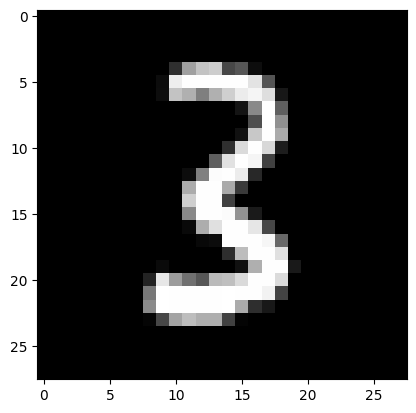

In [56]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [57]:
model, opt = get_model()

In [58]:
def fit():
  for epoch in range(epochs):
    for xb, yb in train_dl:
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      opt.step()
      opt.step()
      opt.zero_grad()
  report(loss, preds, yb)

In [59]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.32, 0.92


(tensor(0.06, grad_fn=<NllLossBackward0>), tensor(1.))

## Random Sampling

In [60]:
import random

In [61]:
class Sampler():
  def __init__(self, ds, shuffle=False):
    self.n = len(ds)
    self.shuffle = shuffle
  def __iter__(self):
    res = list(range(self.n))
    if self.shuffle:
      random.shuffle(res)
    return iter(res)

In [62]:
from itertools import islice

In [63]:
ss = Sampler(train_ds)

In [64]:
it = iter(ss)
for o in range(5):
  print(next(it))

0
1
2
3
4


In [65]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[23297, 49190, 48501, 1374, 11964]

In [66]:
import fastcore.all as fc

In [67]:
class BatchSampler():
  def __init__(self, sampler, bs, drop_last=False):
    fc.store_attr()
  
  def __iter__(self):
    yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [68]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[39627, 20121, 32373, 31794],
 [5105, 23817, 33321, 20752],
 [21028, 2317, 7736, 30255],
 [30567, 41747, 20772, 14817],
 [1679, 26647, 1524, 47901]]

In [69]:
def collate(b):
  xs, ys = zip(*b)
  return torch.stack(xs), torch.stack(ys)

In [70]:
class DataLoader():
  def __init__(self, ds, batchs, collate_fn=collate):
    fc.store_attr()
  
  def __iter__(self):
    yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [71]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [72]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

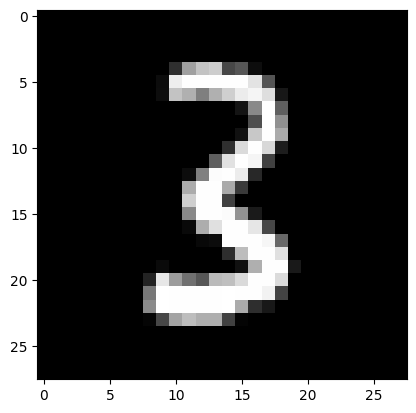

In [73]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

## Multiprocessing DataLoader

In [74]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [77]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [78]:
train_ds.__getitem__([[3,6,8,1]])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [79]:
for o in map(train_ds.__getitem__, ([3,6], [8,1])):
  print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [83]:
class DataLoader:
  def __init__(self, ds, batchs, n_workers=1, collate_fn=collate):
    fc.store_attr()
  
  def __iter__(self):
    with mp.Pool(self.n_workers) as ex:
      yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [84]:
train_dl = DataLoader(train_ds, batchs = train_samp, n_workers=2)
it = iter(train_dl)

In [85]:
next(it)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([2, 7, 9, 6, 6, 6, 3, 1, 4, 9, 7, 5, 9, 4, 0, 8, 9, 9, 6, 0, 1, 9, 4, 0, 4, 9, 5, 6, 6, 0, 9, 9, 3, 3, 9, 6, 6, 6, 8,
         4, 9, 9, 8, 0, 4, 5, 0, 3, 0, 4]))

## Pytorch DataLoader

In [86]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [89]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [90]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn = collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn = collate)

In [91]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.17, 0.92


(tensor(0.12, grad_fn=<NllLossBackward0>), tensor(0.94))

In [92]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers = 2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers = 2)


In [93]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.39, 0.90


(tensor(0.70, grad_fn=<NllLossBackward0>), tensor(0.82))

In [94]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [95]:
next(iter(train_dl))

[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[5, 0, 2, 0, 7, 3, 4, 3, 4, 1, 1, 1, 9, 3, 7, 0, 6, 9, 5, 0, 9, 3, 2, 8, 6, 1, 8, 2, 2, 9, 1, 6, 4, 7, 6, 1, 5, 6, 6,
          1, 0, 6, 5, 8, 4, 9, 3, 4, 3, 8]])]

## Validation

In [96]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss = loss_func(model(xb), yb)
      loss.backward()
      opt.step()
      opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
      tot_loss, tot_acc, count = 0., 0., 0
      for xb, yb in valid_dl:
        pred = model(xb)
        n = len(xb)
        count += n
        tot_loss += loss_func(pred, yb).item() * n
        tot_acc += accuracy(pred, yb).item() * n
    print(epoch, tot_loss/count, tot_acc/count)
  
  return tot_loss/count, tot_acc/count

In [97]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
  return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
          DataLoader(valid_ds, batch_size=bs*2, shuffle=False, **kwargs)
          )

In [98]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.15938207839615642 0.9529000061750412
1 0.1281359902303666 0.9623000061511994
2 0.11384971430059522 0.967700006365776
3 0.12173384747467936 0.9652000045776368
4 0.10598108069971204 0.9720000070333481
